<br>
<img src="https://cdn.slidesharecdn.com/ss_thumbnails/netflixprize-170320014819-thumbnail-4.jpg?cb=1489978383" width='25%'>
<h1 align='center'> Netflix Prize Challenge - Movie Recommendation</h1>
<h2 align='center'> <font color='#FC7307'> Machine Learning </font> </h2>
<h3 align='center'>  Wenyi Hu </h3>
<br>

## <a name='#toc'></a> Table of Contents

1. [Import Libraries](#1.-Import-Libraries)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Machine Learning](#3.-Machine-Learning)
    1. [Baseline Model](#3.1-Baseline-Model)
    2. [SVD in GridSearchCV](#3.2-SVD-in-GridSearchCV)
        1. [Prepare A and B Sets](#3.2.1-Prepare-A-and-B-Sets)
        2. [Build GridSearch Model](#3.2.2-Build-GridSearch-Model)
        3. [Code in One](#3.3.3-Code-in-One)

# 1. Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import random

# from skikit-surprise import functions:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

# 2. Data Preprocessing

In [2]:
# Read all data into a pd dataframe
data = pd.read_csv('data.csv', names=['movie_id', 'user_id', 'rating', 'date'])

# Convert date to datetime type
data['date'] = pd.to_datetime(data['date'])

print(data.nunique())

movie_id     17770
user_id     480189
rating           5
date          2182
dtype: int64


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   movie_id  int64         
 1   user_id   int64         
 2   rating    int64         
 3   date      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.0 GB


In [4]:
data.isnull().sum()

movie_id    0
user_id     0
rating      0
date        0
dtype: int64

In [5]:
data.describe()

,movie_id,user_id,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


A smaller dataset (users gave the most rates on most movies) is chosen for the project, with 1000 top rated movies and 10,000 top users. The 12% of the ratings are retained from the whole records.

In [6]:
df = pd.DataFrame()

group = data.groupby('user_id')['rating'].count().rename('user_rating_cnt')
top_users = group.sort_values(ascending=False)[:10000]

group = data.groupby('movie_id')['rating'].count().rename('movie_rating_cnt')
top_movies = group.sort_values(ascending=False)[:1000]

df = data.join(top_users, how='inner', on='user_id')
df = df.join(top_movies, how='inner', on='movie_id')

df.reset_index(drop=True, inplace=True)

Re-name the users and movies for uniform name from 0 to 10000 and 1000 respectively

In [7]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['user_id'] = enc.fit_transform(df['user_id'].values)
df['movie_id'] = enc.fit_transform(df['movie_id'].values)
#df.to_csv('top_rating_df.csv', header = True, index = False)

In [8]:
n_movies = df['movie_id'].nunique()
n_users = df['user_id'].nunique()
print('The number of movies is:',n_movies)
print('The number of users is',n_users)
print('The number of records (rows) of data processed is',len(df))

The number of movies is: 1000
The number of users is 10000
The number of records (rows) of data processed is 6264018


Correlation

In [9]:
df.corr().style.background_gradient(cmap='coolwarm')

,movie_id,user_id,rating,user_rating_cnt,movie_rating_cnt
movie_id,1.000000,0.000017,0.005035,-0.000355,0.017793
user_id,0.000017,1.000000,0.003720,-0.005607,0.000270
rating,0.005035,0.003720,1.000000,-0.030399,0.085126
user_rating_cnt,-0.000355,-0.005607,-0.030399,1.000000,-0.030387
movie_rating_cnt,0.017793,0.000270,0.085126,-0.030387,1.000000


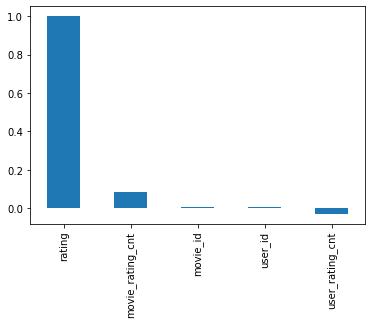

In [10]:
df.corr().loc[:,'rating'].sort_values(ascending = False).plot(kind='bar');

# 3. Machine Learning

## 3.1 Baseline Model
1. Single Value Decomposition(SVD) algorithm is used for matrix factorization.
2. Cross validation with 5 folds is used to train the model.
3. Root Mean Squared Error(RMSE) is uesed to evaluate the model.
4. Apply the model to predict a rating with given user_id and movie_id.

In [11]:
%%time
# Choose user, movie, and rating columns for modelling.
dataframe = df[['user_id','movie_id','rating']]

# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1,5))

# Load a dataset from a pandas dataframe.
dataset = Dataset.load_from_df(dataframe, reader)

# Algo with default parameters
svd = SVD()

# cross validation in 5 folds, measure the result based on RMSE
cross_validate(svd, dataset, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7753  0.7762  0.7751  0.7757  0.7758  0.7756  0.0004  
Fit time          45.81   46.89   46.23   44.98   46.88   46.16   0.72    
Test time         10.20   8.92    9.10    8.29    11.16   9.53    1.02    
CPU times: total: 5min 13s
Wall time: 5min 13s


{'test_rmse': array([0.77531034, 0.77622149, 0.77512104, 0.77572668, 0.77584115]),
 'fit_time': (45.80519485473633,
  46.889283895492554,
  46.2272264957428,
  44.97975945472717,
  46.87786078453064),
 'test_time': (10.201031684875488,
  8.92012882232666,
  9.098432302474976,
  8.290852546691895,
  11.161584377288818)}

In [12]:
# Model prediction with input user_id, movie_id, and rating(optional)
svd.predict(1488844,20)

# 'uid' is user_id, 'iid' is item_id, 'r_ui' is real rating, 'est' is predicted rating

Prediction(uid=1488844, iid=20, r_ui=None, est=3.295636831281422, details={'was_impossible': False})

## 3.2 SVD in GridSearchCV
1. Prepare train/test sets
2. Build a GridSearchCV with a list of parameters
3. Run GridSearchCV to find the best estimator
4. Apply the best estimator to predict the rating

### 3.2.1 Prepare A and B Sets
- A is used for parameter tuning using grid search. 
- B is used for unbiased estimation.

In [13]:
%%time
# Choose user, movie, and rating columns for modelling.
dataframe = df[['user_id','movie_id','rating']]

# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1,5))

# Load the full dataset from a pandas dataframe.
data = Dataset.load_from_df(dataframe, reader)
raw_ratings = data.raw_ratings

# shuffle ratings
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(0.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

CPU times: total: 5.89 s
Wall time: 5.89 s


### 3.2.2 Build GridSearch Model
- Single Value Decomposition(SVD) algorithm is used for matrix factorization.
- Cross validation with 3 folds is used to train the model.
- Root Mean Squared Error(RMSE) is uesed to evaluate the model.
- Fit the model on the training set (A).
- Apply the best estimator to the the RMSE score on testing sets(A and B).

In [14]:
%%time
# Select your best algo with grid search.
print("Grid Search...")
param_grid = {'n_factors': [50, 100, 200],
              'n_epochs': [5, 10, 20], 
              'lr_all': [0.001, 0.002, 0.005],
              'reg_all':[0.01, 0.02, 0.05],
              'random_state':[42, 100]
             }
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
grid_search.fit(data)

Grid Search...
CPU times: total: 5h 16min 25s
Wall time: 5h 16min 31s


In [15]:
# best RMSE score
print('Best RMSE score:',grid_search.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print('Best parameters:', grid_search.best_params["rmse"])


Best RMSE score: 0.7886428381835442
Best parameters: {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02, 'random_state': 100}


In [16]:
# get the best estimator
algo = grid_search.best_estimator["rmse"]

In [17]:
%%time
# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print("Biased RMSE on A,", end="   ")
accuracy.rmse(predictions)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print("Unbiased RMSE on B,", end=" ")
accuracy.rmse(predictions)

Biased RMSE on A,   RMSE: 0.7053
Unbiased RMSE on B, RMSE: 0.7704
CPU times: total: 1min 41s
Wall time: 1min 41s


0.7704406223880562

In [18]:
# Model prediction with input user_id, movie_id, and rating(optional)
algo.predict(1488844,20)

# 'uid' is user_id, 'iid' is item_id, 'r_ui' is real rating, 'est' is predicted rating

Prediction(uid=1488844, iid=20, r_ui=None, est=3.263126739109162, details={'was_impossible': False})

### 3.3.3 Code in One

In [19]:
%%time
# Choose user, movie, and rating columns for modelling.
dataframe = df[['user_id','movie_id','rating']]

# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1,5))

# Load the full dataset from a pandas dataframe.
data = Dataset.load_from_df(dataframe, reader)
raw_ratings = data.raw_ratings

# shuffle ratings
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(0.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

# Select your best algo with grid search.
print("Grid Search...")
param_grid = {'n_factors': [50, 100, 200],
              'n_epochs': [5, 10, 20], 
              'lr_all': [0.001, 0.002, 0.005],
              'reg_all':[0.01, 0.02, 0.05],
              'random_state':[42, 100]
             }
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
grid_search.fit(data)

# Best RMSE score
print('Best RMSE score:',grid_search.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
print('Best parameters:', grid_search.best_params["rmse"])

# Get the best estimator
algo = grid_search.best_estimator["rmse"]

# Retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on A,", end="   ")
accuracy.rmse(predictions)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print("Unbiased accuracy on B,", end=" ")
accuracy.rmse(predictions)

Grid Search...
Best RMSE score: 0.7885261359787004
Best parameters: {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02, 'random_state': 100}
Biased accuracy on A,   RMSE: 0.7056
Unbiased accuracy on B, RMSE: 0.7719
CPU times: total: 4h 53min 10s
Wall time: 4h 53min 13s


0.7719481221793304